# **Customer Churn Prediction**

#### **What is customer churn?**  
Customer churn refers to the percentage of customers who stop using a company's product or service within a given time frame. This metric helps businesses gauge customer satisfaction and loyalty while also providing insights into potential revenue fluctuations.

Churn is especially critical for subscription-based businesses, such as SaaS companies, which rely on recurring revenue. Understanding churn patterns allows them to anticipate financial impact and take proactive measures.

Also known as customer attrition, churn is the opposite of customer retention, which focuses on maintaining long-term customer relationships. Reducing churn should be a key part of any customer engagement strategy, ensuring consistent interactions between businesses and their customers, whether online or in person.

A strong customer retention plan plays a crucial role in minimizing churn. Companies should track churn rates regularly to assess their risk of revenue loss and identify areas for improvement.

<br>

**Source:** IBM. Customer Churn. Retrieved from https://www.ibm.com/think/topics/customer-churn

---

**Dataset:** [Kaggle Customer ChurnDataset](https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset)

Prepare the libraries.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import shap

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

c:\Users\Juls\Desktop\dsml-projects\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset/s.

In [3]:
pd.pandas.set_option('display.max_columns',None)

train_path = '../../data/CustomerChurnDataset/customer_churn_dataset-testing-master.csv'
test_path = '../../data/CustomerChurnDataset/customer_churn_dataset-training-master.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

Since we saw in our EDA that we only have 1 row of missing value/s from test_df lets drop that row.  
Prepare the train and test datasets.

In [4]:
# drop missing values 
test_df.dropna(inplace=True)
train_df.dropna(inplace=True)

# drop customer id column
train_df = train_df.drop(columns=['CustomerID'])
test_df = test_df.drop(columns=['CustomerID'])

y_train = train_df['Churn']
x_train = train_df.drop(columns=['Churn'])

y_test = test_df['Churn']
x_test = test_df.drop(columns=['Churn'])

Get the numerical and categorical features.

In [5]:
categorical_features = x_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = x_train.select_dtypes(include=['int64','float64']).columns.tolist()

print(categorical_features)
print(numerical_features)

['Gender', 'Subscription Type', 'Contract Length']
['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']


Prepare the preprocessor for the pipeline.

In [6]:
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

Set up the hyperparameters for tuning.

In [7]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

params_space = {
    'eta': hp.uniform('eta', 0.01,0.2),
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,2),
    'reg_alpha' : hp.quniform('reg_alpha', 10,150,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'subsample': hp.uniform('subsample', 0.5,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 10),
    'scale_pos_weight': hp.uniform('scale_pos_weight', 1, scale_pos_weight*2),
    'max_delta_step': hp.quniform('max_delta_step', 1, 10, 1),
    'seed': 0
}


def objective(params):
    # convert the quniforms into int since they are float
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['reg_alpha'] = int(params['reg_alpha'])
    # params['scale_pos_weight'] = scale_pos_weight 
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', XGBClassifier(**params, eval_metric="logloss"))
    ])

    pipeline.fit(x_train, y_train)
    
    # y_pred = pipeline.predict(x_test)
    y_proba = pipeline.predict_proba(x_test)
    
    auc = roc_auc_score(y_test, y_proba[:, 1]) 
    print(f"Params: {params}, AUC-ROC: {auc:.4f}")

    return {'loss': -auc, 'status': STATUS_OK}

Run the hyperparameter tuning.


In [8]:
# trials = Trials()

# best_params = fmin(
#     fn = objective,
#     space = params_space,
#     algo = tpe.suggest,
#     max_evals = 100,
#     trials = trials
# )

# print("\n✅ Best Hyperparameters Found:", best_params)

Get the best hyperparameters.


In [9]:
# int_params = {"max_depth", "n_estimators", "min_child_weight", "reg_alpha"}

# def convert_params(params):
#     return {k: int(v) if k in int_params else float(v) for k, v in params.items()}

# best_params = convert_params(best_params)

Create the pipeline.

In [10]:
# saved the hyper param with auc_roc = 0.9...
best_params = {'colsample_bytree': 0.6450661685580115,
 'eta': 0.04029066638221944,
 'gamma': 1.2790951062735147,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 100,
 'reg_alpha': 12,
 'reg_lambda': 0.5523549844203051,
 'subsample': 0.9400424989480096}

In [11]:
xgb = XGBClassifier(**best_params)

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', xgb)
])

Train the model and make predictions.

In [12]:
pipeline.fit(x_train, y_train)

y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test) 

Evaluate the model.

In [13]:
def evaluate_model(test, pred, proba):
    auc_roc = roc_auc_score(test, proba[:, 1]) 
    
    print("XGBoost Classification Report:\n", classification_report(test, pred))
    # print("XGBoost AUC-ROC:", roc_auc_score(test, pred))
    print(f"XGBoost AUC-ROC: {auc_roc:.4f}")
    
evaluate_model(y_test, y_pred, y_proba)

XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.68    190833
         1.0       0.99      0.27      0.43    249999

    accuracy                           0.59    440832
   macro avg       0.75      0.63      0.55    440832
weighted avg       0.78      0.59      0.53    440832

XGBoost AUC-ROC: 0.9006


Try threshold tuning.

In [14]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba[:, 1])
f1_scores = (2 * precisions * recalls) / (precisions + recalls)
best_f1_index = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_index]

print(f"Best F1-Score Threshold: {best_f1_threshold:.3f}")

y_pred_best_f1 = (y_proba[:, 1] > best_f1_threshold).astype(int)

evaluate_model(y_test, y_pred_best_f1, y_proba)


Best F1-Score Threshold: 0.022
XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.71      0.78    190833
         1.0       0.80      0.91      0.85    249999

    accuracy                           0.82    440832
   macro avg       0.83      0.81      0.82    440832
weighted avg       0.83      0.82      0.82    440832

XGBoost AUC-ROC: 0.9006


Confusion matrix

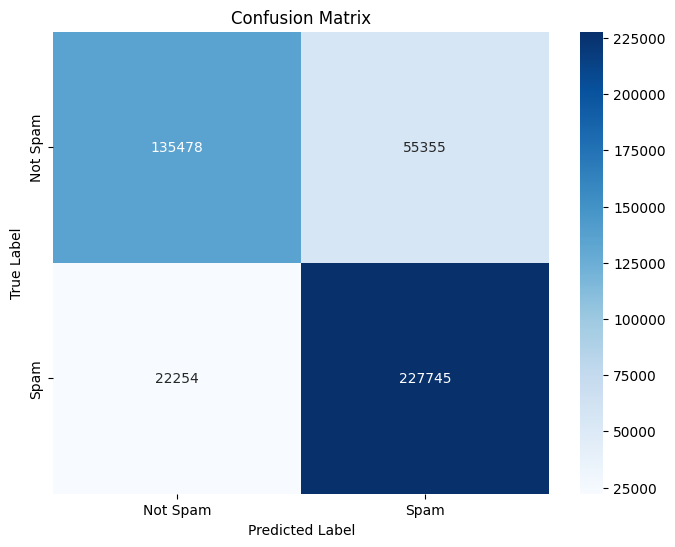

In [28]:
cm = confusion_matrix(y_test, y_pred_best_f1)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

SHAP

In [ ]:
trained_xgb = pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(trained_xgb)
shap_values = explainer(preprocessor.transform(x_test))
transformed_feature_names = preprocessor.get_feature_names_out()

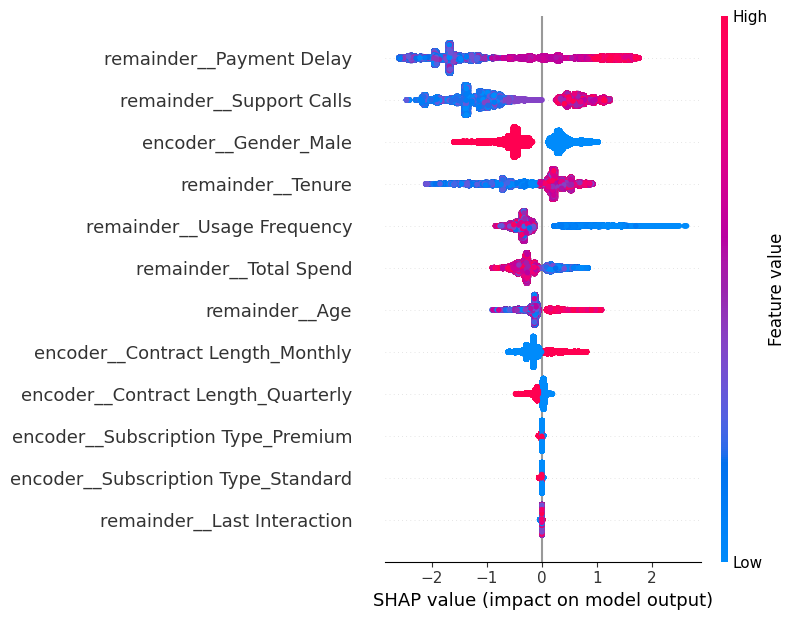

In [ ]:
shap.summary_plot(shap_values, preprocessor.transform(x_test), feature_names=transformed_feature_names)

### **Churn Model Performance Summary**
**Accuracy:** 82%  
**Churn detection rate (recall):** 91%  
**Precision for churn predictions:** 80%  
**F1-score for churn:** 0.85  
**AUC-ROC:** 0.9006  

### **Conclusion**
The model is now highly effective at identifying customers at risk of churning, capturing 91% of actual churners. This high recall is particularly valuable in churn prediction, as it minimizes missed opportunities for retention interventions. With 80% precision, the model maintains good reliability in its churn predictions, meaning retention resources won't be significantly wasted on false positives.

The optimal threshold of 0.022 is notably low, indicating that even customers with relatively small churn indicators should be flagged for attention. This aligns with the SHAP analysis showing that payment delays and support calls are strong churn predictors.

This balanced performance makes the model suitable for deployment in a real-world customer retention program, where it can effectively direct intervention efforts toward the right customers before they churn.